<a href="https://colab.research.google.com/github/mannat244/ML_Lab/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Decision Tree**

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import arff
from io import StringIO
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score
)


In [ ]:
def load_keel_dat(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()

    cleaned = []
    for line in lines:
        l = line.lower()
        if l.startswith("@input") or l.startswith("@output"):
            continue
        cleaned.append(line)

    data, meta = arff.loadarff(StringIO("".join(cleaned)))
    df = pd.DataFrame(data)

    X = df.iloc[:, :-1].values.astype(float)
    y = df.iloc[:, -1].values
    y = np.array([label.decode("utf-8") for label in y])

    return X, y

In [ ]:
BASE_PATH = "/content/"

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_text


In [ ]:
def get_dt_model(algo_name):
    if algo_name == "ID3":
        return DecisionTreeClassifier(
            criterion="entropy",
            random_state=42
        )

    elif algo_name == "C4.5":
        return DecisionTreeClassifier(
            criterion="entropy",
            min_samples_leaf=5,
            random_state=42
        )

    elif algo_name == "CART":
        return DecisionTreeClassifier(
            criterion="gini",
            random_state=42
        )

    else:
        raise ValueError("Invalid algorithm name")


In [ ]:
def evaluate_dt_5fold(dataset_name, algo_name):
    fold_results = []

    for fold in range(1, 6):

        X_train, y_train = load_keel_dat(
            f"{BASE_PATH}/{dataset_name}-5-{fold}tra.dat"
        )

        X_test, y_test = load_keel_dat(
            f"{BASE_PATH}/{dataset_name}-5-{fold}tst.dat"
        )

        # Encode labels
        le = LabelEncoder()
        y_train_enc = le.fit_transform(y_train)
        y_test_enc = le.transform(y_test)

        # Get model
        model = get_dt_model(algo_name)

        # Train
        model.fit(X_train, y_train_enc)

        # Predict
        y_pred = model.predict(X_test)

        # Store fold output
        fold_results.append((y_test_enc, y_pred))

        print(f"{algo_name} | Fold {fold} completed")

    return fold_results

In [ ]:
# ---- TEST RUN (SANITY CHECK) ----

dataset_name = "iris"   # change later
algo_name = "ID3"

fold_outputs = evaluate_dt_5fold(dataset_name, algo_name)

print("\nNumber of folds processed:", len(fold_outputs))
print("Sample output shape (y_true, y_pred):",
      fold_outputs[0][0].shape,
      fold_outputs[0][1].shape)


ID3 | Fold 1 completed
ID3 | Fold 2 completed
ID3 | Fold 3 completed
ID3 | Fold 4 completed
ID3 | Fold 5 completed

Number of folds processed: 5
Sample output shape (y_true, y_pred): (30,) (30,)


In [ ]:
dataset_name = "iris"

for algo in ["ID3", "C4.5", "CART"]:
    print(f"\nRunning {algo} on {dataset_name}")
    evaluate_dt_5fold(dataset_name, algo)



Running ID3 on iris
ID3 | Fold 1 completed
ID3 | Fold 2 completed
ID3 | Fold 3 completed
ID3 | Fold 4 completed
ID3 | Fold 5 completed

Running C4.5 on iris
C4.5 | Fold 1 completed
C4.5 | Fold 2 completed
C4.5 | Fold 3 completed
C4.5 | Fold 4 completed
C4.5 | Fold 5 completed

Running CART on iris
CART | Fold 1 completed
CART | Fold 2 completed
CART | Fold 3 completed
CART | Fold 4 completed
CART | Fold 5 completed


In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


In [ ]:
def false_alarm_rate(cm):
    fp = cm.sum(axis=0) - np.diag(cm)
    tn = cm.sum() - (fp + cm.sum(axis=1))
    return np.mean(fp / (fp + tn))


In [ ]:
def g_mean(cm):
    recalls = []
    for i in range(len(cm)):
        recall_i = cm[i, i] / cm[i].sum()
        recalls.append(recall_i)
    return np.prod(recalls) ** (1 / len(recalls))


In [ ]:
def compute_auc(model, X_test, y_test_enc):
    y_binary = (y_test_enc == 0).astype(int)
    probs = model.predict_proba(X_test)[:, 0]
    return roc_auc_score(y_binary, probs)


In [33]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score, accuracy_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np


def evaluate_cart_metrics_5fold(dataset_name, show_reports=True):

    precision_list = []
    recall_list = []
    f1_list = []
    auc_list = []
    far_list = []
    gmean_list = []

    tree_fold1 = None
    class_names_fold1 = None
    n_features_fold1 = None

    for fold in range(1, 6):

        # -------- Load data --------
        X_train, y_train = load_keel_dat(
            f"{BASE_PATH}/{dataset_name}-5-{fold}tra.dat"
        )
        X_test, y_test = load_keel_dat(
            f"{BASE_PATH}/{dataset_name}-5-{fold}tst.dat"
        )

        # -------- Encode labels --------
        le = LabelEncoder()
        y_train_enc = le.fit_transform(y_train)
        y_test_enc = le.transform(y_test)

        # -------- CART model (Gini) --------
        model = DecisionTreeClassifier(
            criterion="gini",
            random_state=42
        )
        model.fit(X_train, y_train_enc)

        y_pred = model.predict(X_test)

        # -------- Save Fold-1 tree --------
        if fold == 1:
            tree_fold1 = model
            class_names_fold1 = le.classes_
            n_features_fold1 = X_train.shape[1]

        labels_present = np.unique(y_test_enc)
        target_names_present = le.classes_[labels_present]

        # -------- Classification report --------
        report = classification_report(
            y_test_enc,
            y_pred,
            labels=labels_present,
            target_names=target_names_present,
            output_dict=True,
            zero_division=0
        )

        precision_list.append(report["macro avg"]["precision"])
        recall_list.append(report["macro avg"]["recall"])
        f1_list.append(report["macro avg"]["f1-score"])

        # -------- Confusion matrix --------
        cm = confusion_matrix(y_test_enc, y_pred, labels=labels_present)

        # -------- FAR --------
        fp = cm.sum(axis=0) - np.diag(cm)
        tn = cm.sum() - (fp + cm.sum(axis=1))
        far_list.append(np.mean(fp / (fp + tn)))

        # -------- G-Mean --------
        recalls = [cm[i, i] / cm[i].sum() for i in range(len(cm))]
        gmean_list.append(np.prod(recalls) ** (1 / len(recalls)))

        # -------- AUC (OvR) --------
        y_binary = (y_test_enc == labels_present[0]).astype(int)
        probs = model.predict_proba(X_test)[:, labels_present[0]]
        auc_list.append(roc_auc_score(y_binary, probs))

        # -------- Display --------
        if show_reports:
            print(f"\n📌 {dataset_name.upper()} | CART | Fold {fold}")
            print(
                classification_report(
                    y_test_enc,
                    y_pred,
                    labels=labels_present,
                    target_names=target_names_present,
                    zero_division=0
                )
            )

            disp = ConfusionMatrixDisplay(
                confusion_matrix=cm,
                display_labels=target_names_present
            )
            disp.plot(cmap="Blues")
            plt.title(f"{dataset_name.upper()} | CART | Fold {fold}")
            plt.show()

    # -------- Tree visualization (Fold-1) --------
    print(f"\n🌳 CART Decision Tree ({dataset_name.upper()} | Fold 1)\n")

    plt.figure(figsize=(22, 10))
    tree.plot_tree(
        tree_fold1,
        feature_names=[f"X{i}" for i in range(n_features_fold1)],
        class_names=class_names_fold1,
        filled=True,
        proportion=True,
        rounded=True
    )
    plt.title(f"{dataset_name.upper()} | CART | Fold 1 Decision Tree")
    plt.show()

    return {
        "Mean Precision": np.mean(precision_list),
        "Mean Recall": np.mean(recall_list),
        "Mean F-measure": np.mean(f1_list),
        "Mean False Alarm Rate": np.mean(far_list),
        "Mean G-Mean": np.mean(gmean_list),
        "Mean AUC": np.mean(auc_list)
    }



====== DATASET: IRIS ======

--- CART ---

📌 IRIS | CART | Fold 1
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.91      1.00      0.95        10
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



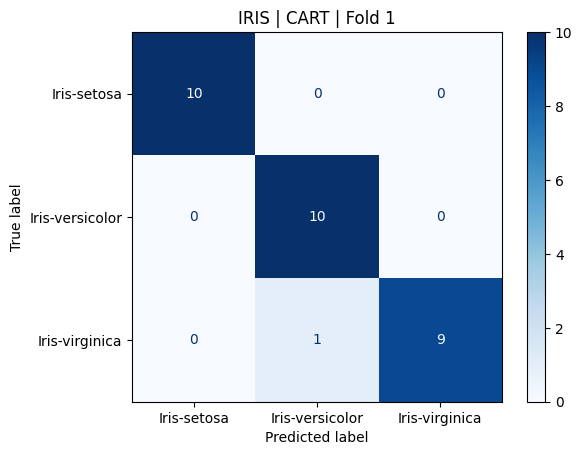


📌 IRIS | CART | Fold 2
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



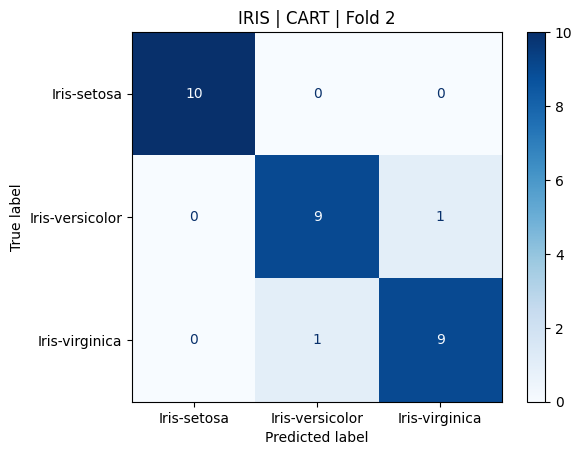


📌 IRIS | CART | Fold 3
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



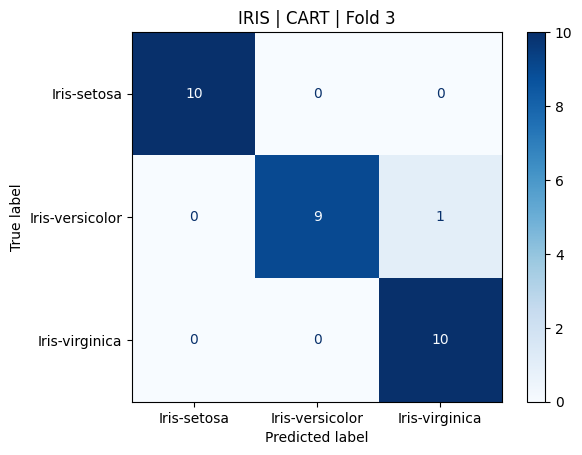


📌 IRIS | CART | Fold 4
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.80      0.89        10
 Iris-virginica       0.83      1.00      0.91        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



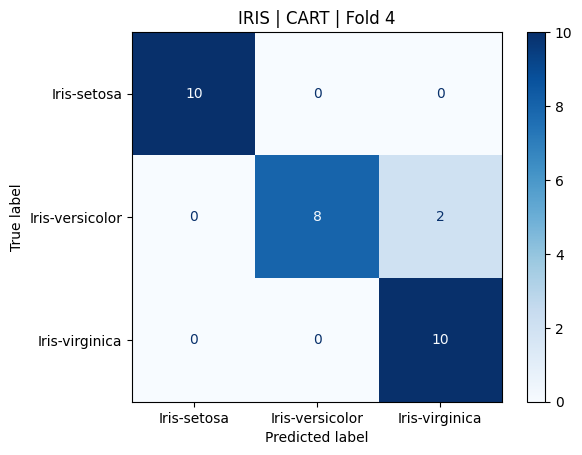


📌 IRIS | CART | Fold 5
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.82      0.90      0.86        10
 Iris-virginica       0.89      0.80      0.84        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



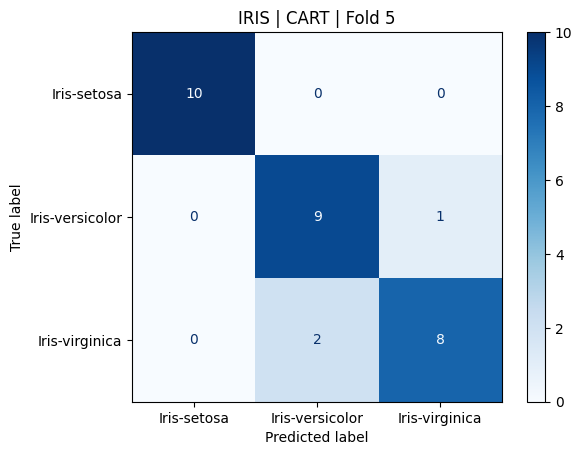


🌳 Decision Tree (IRIS | CART | Fold 1)



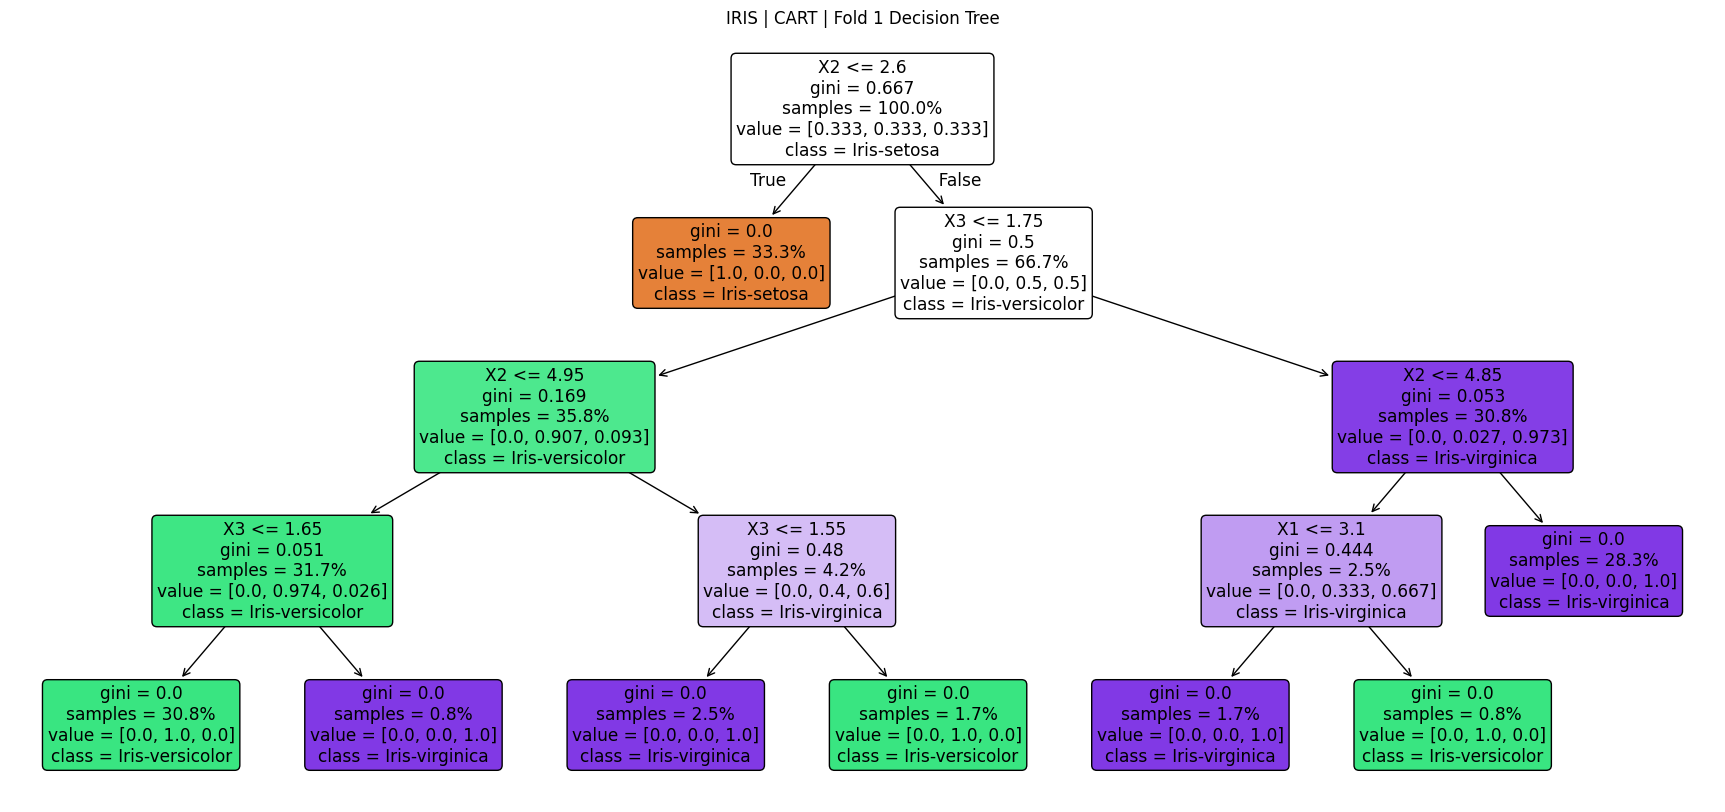

Mean Precision: 0.9439
Mean Recall: 0.9400
Mean F-measure: 0.9398
Mean AUC: 1.0000

====== DATASET: WISCONSIN ======

--- CART ---

📌 WISCONSIN | CART | Fold 1
              precision    recall  f1-score   support

           2       0.93      0.97      0.95        89
           4       0.93      0.88      0.90        48

    accuracy                           0.93       137
   macro avg       0.93      0.92      0.93       137
weighted avg       0.93      0.93      0.93       137



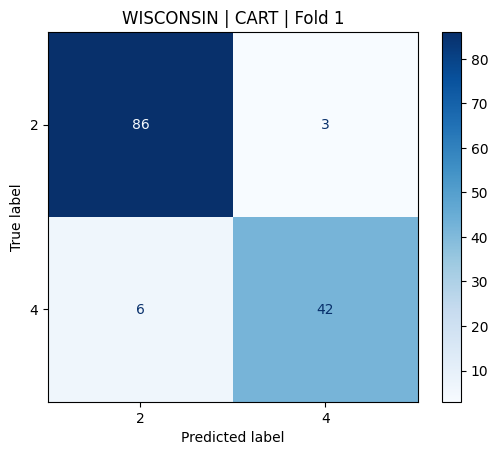


📌 WISCONSIN | CART | Fold 2
              precision    recall  f1-score   support

           2       0.96      0.98      0.97        90
           4       0.96      0.92      0.94        48

    accuracy                           0.96       138
   macro avg       0.96      0.95      0.95       138
weighted avg       0.96      0.96      0.96       138



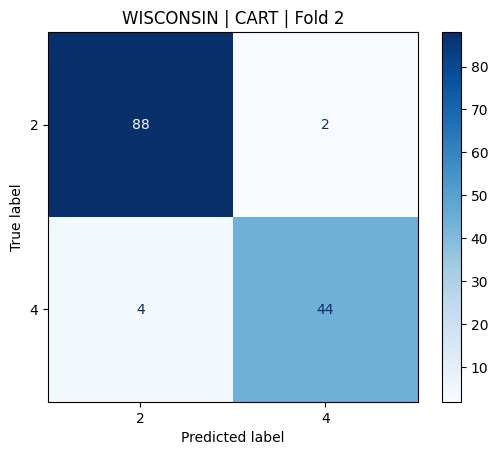


📌 WISCONSIN | CART | Fold 3
              precision    recall  f1-score   support

           2       0.97      0.93      0.95        89
           4       0.88      0.94      0.91        47

    accuracy                           0.93       136
   macro avg       0.92      0.93      0.93       136
weighted avg       0.94      0.93      0.93       136



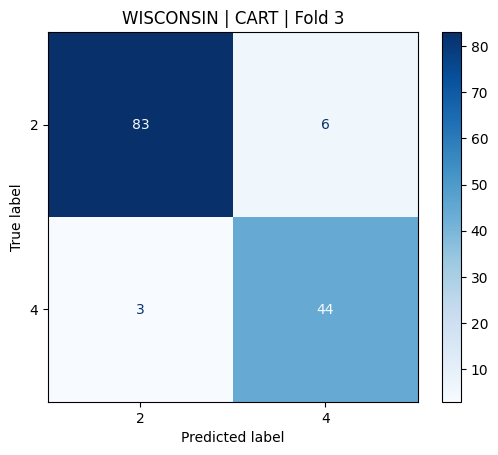


📌 WISCONSIN | CART | Fold 4
              precision    recall  f1-score   support

           2       0.95      0.97      0.96        86
           4       0.94      0.92      0.93        48

    accuracy                           0.95       134
   macro avg       0.95      0.94      0.94       134
weighted avg       0.95      0.95      0.95       134



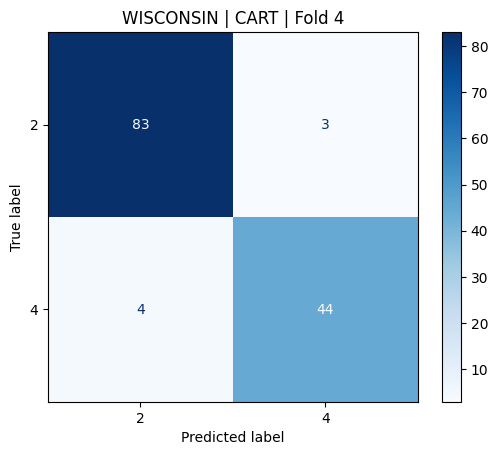


📌 WISCONSIN | CART | Fold 5
              precision    recall  f1-score   support

           2       0.98      0.97      0.97        90
           4       0.94      0.96      0.95        48

    accuracy                           0.96       138
   macro avg       0.96      0.96      0.96       138
weighted avg       0.96      0.96      0.96       138



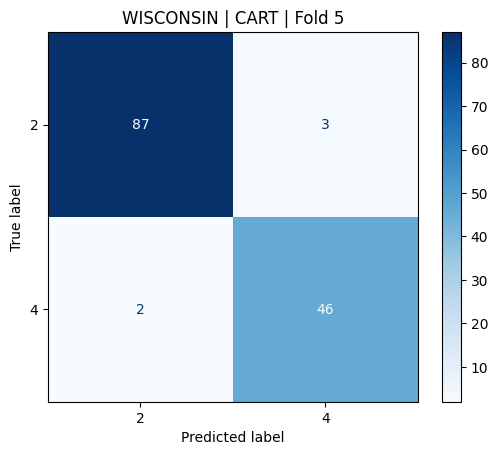


🌳 Decision Tree (WISCONSIN | CART | Fold 1)



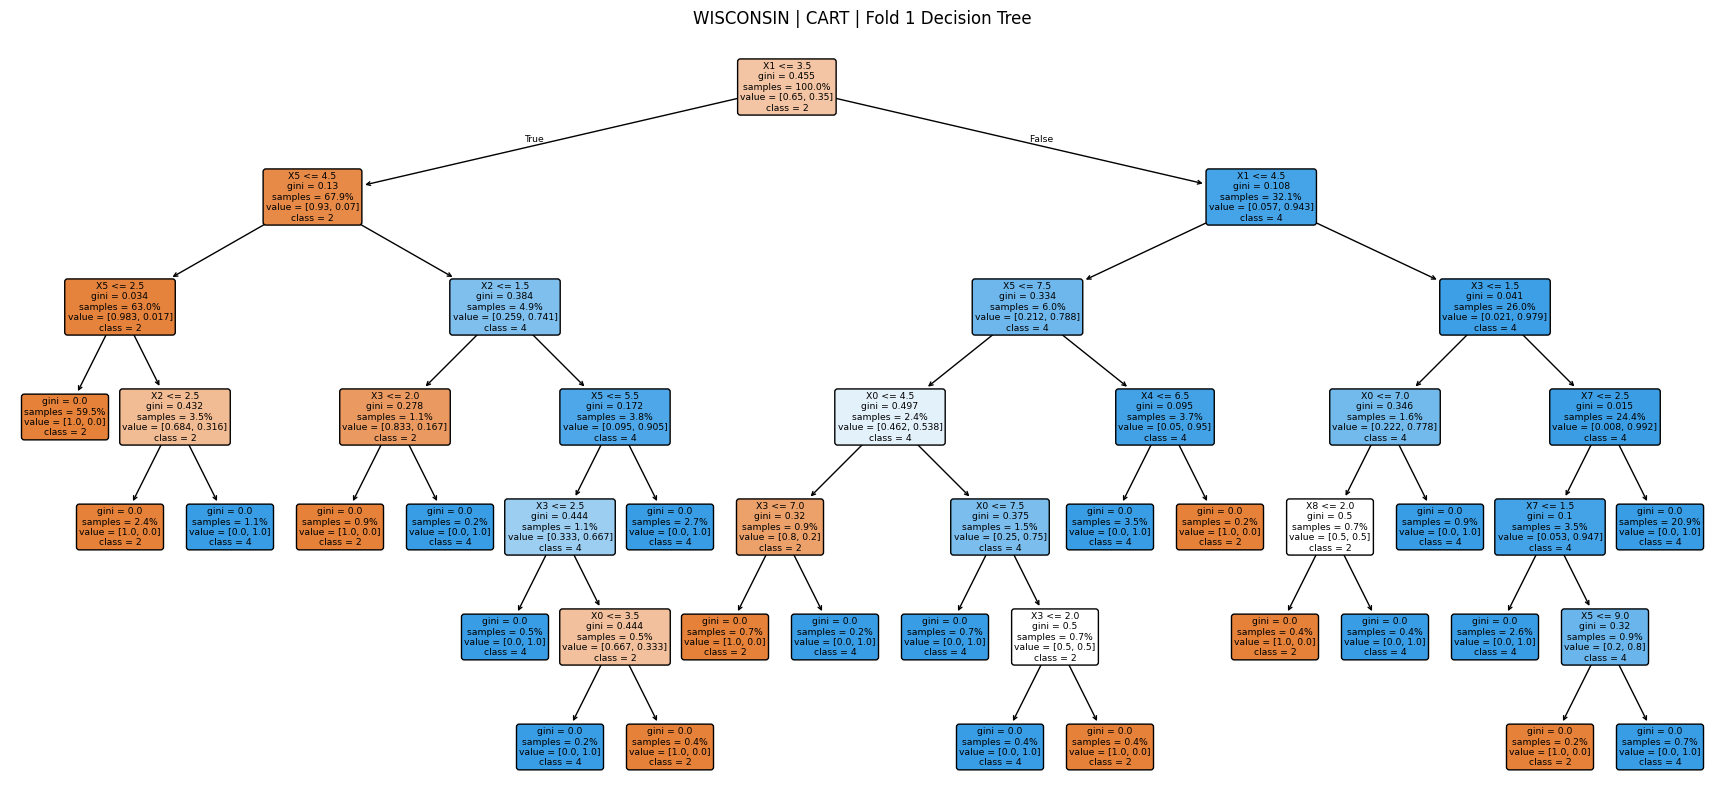

Mean Precision: 0.9433
Mean Recall: 0.9411
Mean F-measure: 0.9419
Mean AUC: 0.9411

====== DATASET: HABERMAN ======

--- CART ---

📌 HABERMAN | CART | Fold 1
              precision    recall  f1-score   support

    negative       0.76      0.78      0.77        45
    positive       0.38      0.35      0.36        17

    accuracy                           0.66        62
   macro avg       0.57      0.57      0.57        62
weighted avg       0.66      0.66      0.66        62



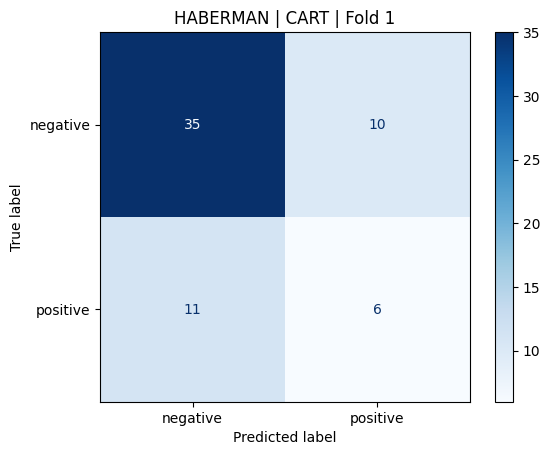


📌 HABERMAN | CART | Fold 2
              precision    recall  f1-score   support

    negative       0.77      0.73      0.75        45
    positive       0.33      0.38      0.35        16

    accuracy                           0.64        61
   macro avg       0.55      0.55      0.55        61
weighted avg       0.65      0.64      0.65        61



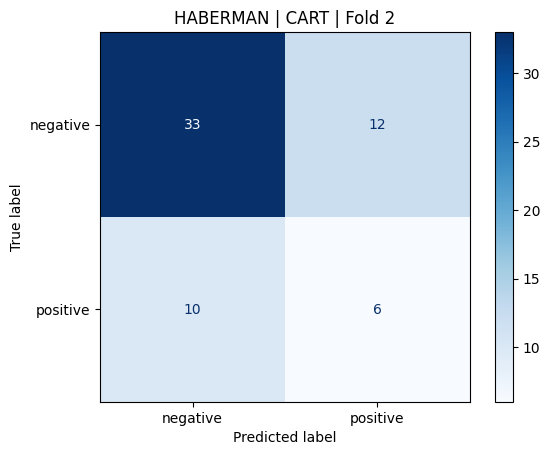


📌 HABERMAN | CART | Fold 3
              precision    recall  f1-score   support

    negative       0.78      0.78      0.78        45
    positive       0.38      0.38      0.38        16

    accuracy                           0.67        61
   macro avg       0.58      0.58      0.58        61
weighted avg       0.67      0.67      0.67        61



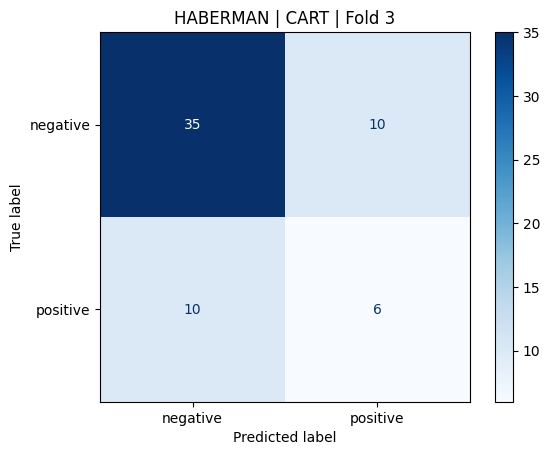


📌 HABERMAN | CART | Fold 4
              precision    recall  f1-score   support

    negative       0.73      0.78      0.75        45
    positive       0.23      0.19      0.21        16

    accuracy                           0.62        61
   macro avg       0.48      0.48      0.48        61
weighted avg       0.60      0.62      0.61        61



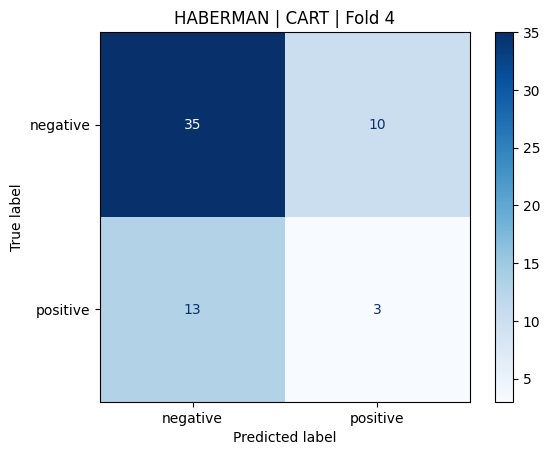


📌 HABERMAN | CART | Fold 5
              precision    recall  f1-score   support

    negative       0.77      0.82      0.80        45
    positive       0.38      0.31      0.34        16

    accuracy                           0.69        61
   macro avg       0.58      0.57      0.57        61
weighted avg       0.67      0.69      0.68        61



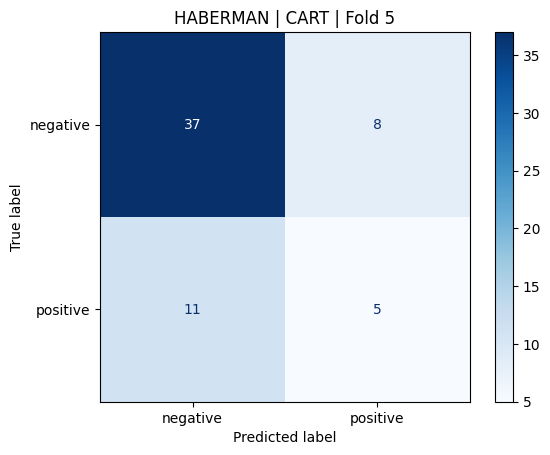


🌳 Decision Tree (HABERMAN | CART | Fold 1)



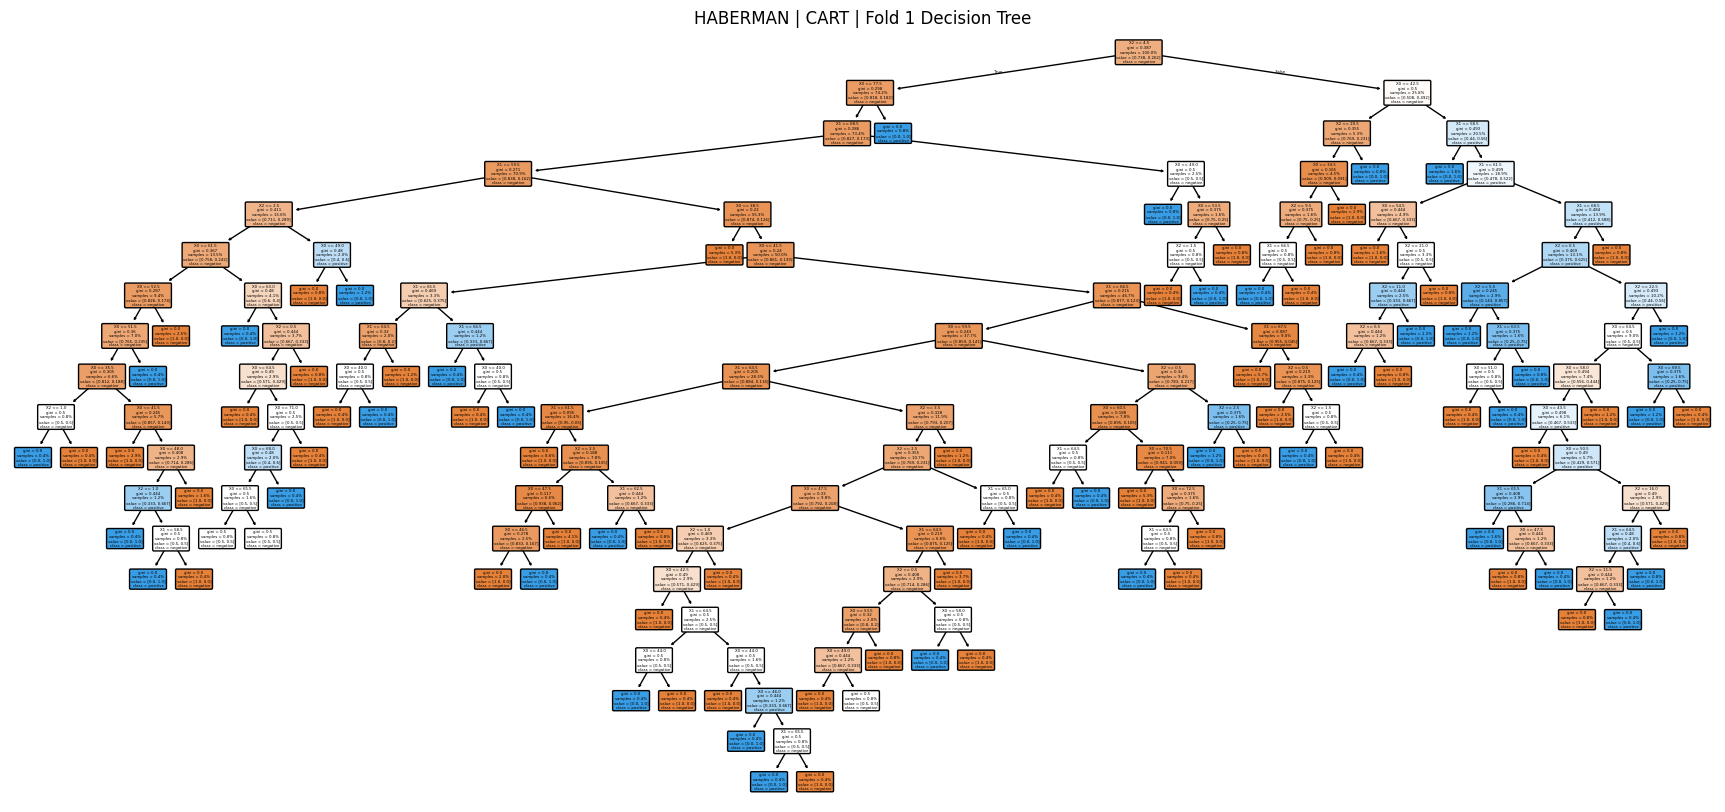

Mean Precision: 0.5505
Mean Recall: 0.5492
Mean F-measure: 0.5489
Mean AUC: 0.5464

====== DATASET: WINE ======

--- CART ---

📌 WINE | CART | Fold 1
              precision    recall  f1-score   support

           1       1.00      0.92      0.96        12
           2       0.93      1.00      0.97        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



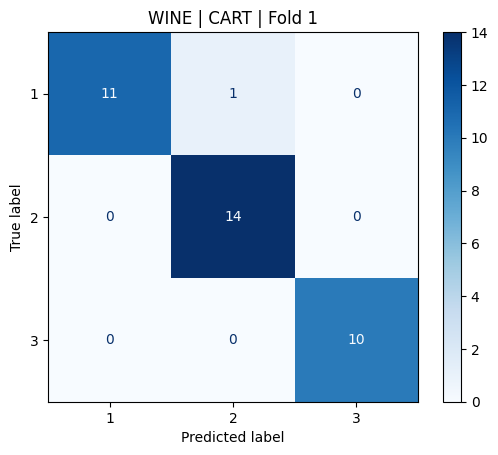


📌 WINE | CART | Fold 2
              precision    recall  f1-score   support

           1       1.00      0.83      0.91        12
           2       0.88      1.00      0.93        14
           3       1.00      1.00      1.00        10

    accuracy                           0.94        36
   macro avg       0.96      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36



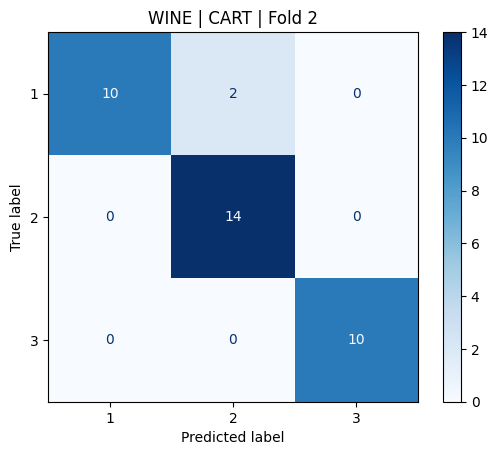


📌 WINE | CART | Fold 3
              precision    recall  f1-score   support

           1       0.79      0.92      0.85        12
           2       1.00      0.86      0.92        14
           3       0.90      0.90      0.90        10

    accuracy                           0.89        36
   macro avg       0.90      0.89      0.89        36
weighted avg       0.90      0.89      0.89        36



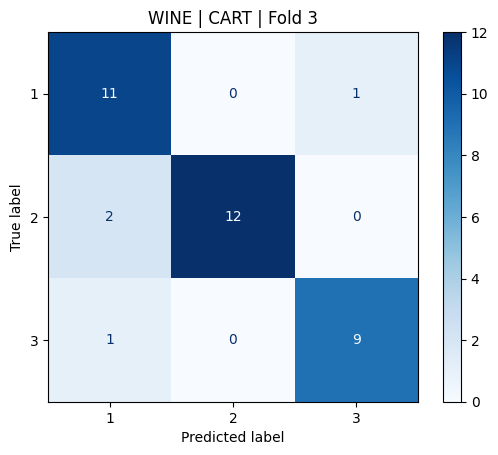


📌 WINE | CART | Fold 4
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       0.93      1.00      0.97        14
           3       1.00      0.89      0.94         9

    accuracy                           0.97        35
   macro avg       0.98      0.96      0.97        35
weighted avg       0.97      0.97      0.97        35



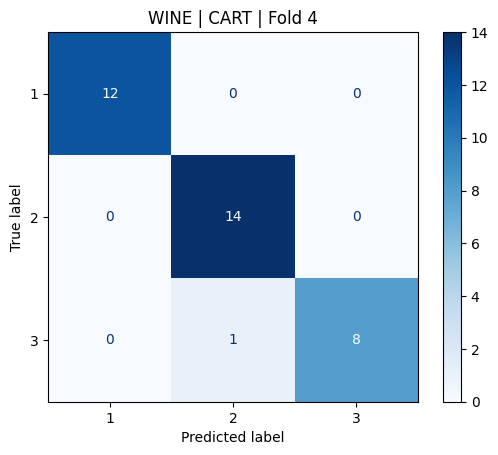


📌 WINE | CART | Fold 5
              precision    recall  f1-score   support

           1       1.00      0.91      0.95        11
           2       0.87      0.87      0.87        15
           3       0.80      0.89      0.84         9

    accuracy                           0.89        35
   macro avg       0.89      0.89      0.89        35
weighted avg       0.89      0.89      0.89        35



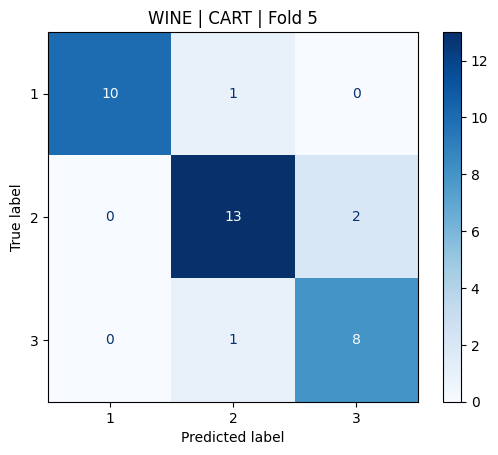


🌳 Decision Tree (WINE | CART | Fold 1)



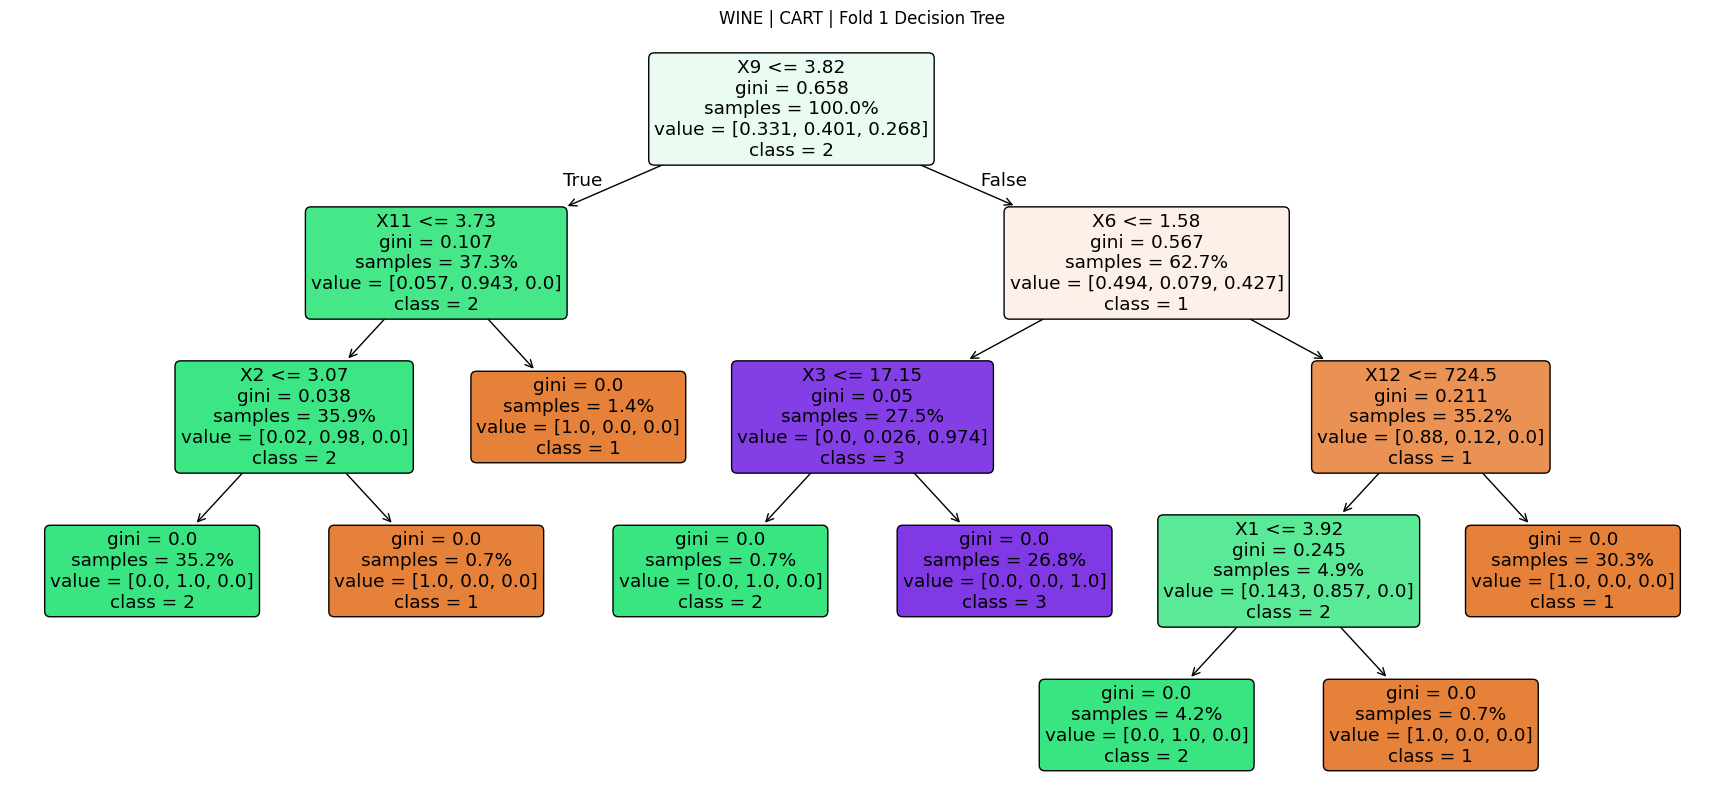

Mean Precision: 0.9396
Mean Recall: 0.9318
Mean F-measure: 0.9334
Mean AUC: 0.9451


In [36]:
datasets = ["iris", "wisconsin", "haberman","wine"]

for dataset in datasets:
    print(f"\n====== DATASET: {dataset.upper()} ======")

    for algo in [ "CART"]:
        print(f"\n--- {algo} ---")
        results = evaluate_dt_metrics_5fold(dataset, algo)

        for k, v in results.items():
            print(f"{k}: {v:.4f}")
